# Import Packages

In [1]:
from math import log10
import nidaqmx
from nidaqmx import Task
import numpy as np
from numpy import sin, cos, arctan, pi, exp
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.lines import Line2D

# Define Functions

In [2]:
# Create and output program potential, acquire Ecell and iwRm and determine Yin, Yout, Zin and Zout
def measure_Y_and_Z(E_DC, E_AC, freq, Rm, samp_rate, extra_samps, ai1_delay):
    
    ''' 
    This function creates and writes the program potential array into the ao0 output of the DAQ
    and then initiates its output to Ein of the pstat. 
    At the same time, potential acquisitions are made at the ai0 and ai1
    inputs of the DAQ. ai0 measures Ecell while ai1 measures iwRm.
    Then, the admittances and impedances (Zin and Zout) are determined from the middle num_samps 
    data values, accounting for the delay of ai1 relative to ai0.

    Output: Yin, Yout, Zin, Zout 
    '''   
    
    num_samps = int(20*samp_rate/freq)  # 20 periods at frequency of interest
    time = np.arange(0, (extra_samps + num_samps + extra_samps),1)/samp_rate # padded with extra samples of start and end
    # Set up potential profile
    program_pot = E_DC * np.ones(num_samps+2*extra_samps) # DC program potential array to apply
    program_pot = program_pot + E_AC*sin(2*pi*freq*time) # Add on AC program potential
    '''Get device name '''
    # get a list of all devices connected
    all_devices = list(nidaqmx.system.System.local().devices)
    # get name of first device
    dev_name = all_devices[0].name
    #print(dev_name)

    ''' set potential profile and acquire data'''
    with Task() as task_o, Task() as task_i, Task():
        
        # add ai0 and ai1 input channel to read Ecell and iwRm
        task_i.ai_channels.add_ai_voltage_chan(dev_name + "/ai0:1", min_val=-10.0, max_val=10.0)
        # add ai0 output ao0 channel for setting the potential profile
        task_o.ao_channels.add_ao_voltage_chan(dev_name + "/ao0", min_val=-10.0, max_val=10.0)
        
        # Set sampling rates for input and output channels
        task_i.timing.cfg_samp_clk_timing(rate = samp_rate, samps_per_chan=(num_samps+2*extra_samps)) 
        task_o.timing.cfg_samp_clk_timing(rate = samp_rate, samps_per_chan=(num_samps+2*extra_samps)) 

        # set up a digital trigger for the output channel to set the potential
        task_o.triggers.start_trigger.cfg_dig_edge_start_trig('/'+ dev_name +'/ai/StartTrigger')
        # define output channel task. Task will only execute when the output channel trigger is activated
        task_o.write(program_pot, auto_start = False)
        task_o.start()                                                                                                                     
        
        # Acquire data from input channels. This will trigger the potential profile to be set by the output channel
        acquired_data = task_i.read(number_of_samples_per_channel=(num_samps+2*extra_samps), timeout=nidaqmx.constants.WAIT_INFINITELY)
        
   # create and trim Ecell, iwRm, iw and time arrays
    Ecell = np.array(acquired_data[0])
    Ecell = Ecell[extra_samps:(extra_samps+num_samps)] # keep only the middle num_samps worth of Ecell
    iwRm = np.array(acquired_data[1]) 
    iwRm = iwRm[extra_samps:(extra_samps+num_samps)] # keep only the middle num_samps worth of iwRm
    iw = iwRm/Rm
    time = time[extra_samps:(extra_samps+num_samps)] # keep only the middle nums amps worth of data

    '''Calculate Admittance'''
    # Ecell inner products with sine and cosine bases
    Ecell_in = np.dot(Ecell, sin(2*pi*freq*time))/(0.5*num_samps)
    Ecell_out= np.dot(Ecell, cos(2*pi*freq*time))/(0.5*num_samps)

    # Ecell phase and mangnitude 
    Ecell_phi = arctan(Ecell_out/Ecell_in)
    Ecell_mag = (Ecell_in**2+Ecell_out**2)**0.5

    # iw inner product with sine and cosine bases 
    iw_in = np.dot(iw, sin(2*pi*freq*(time+ai1_delay)+Ecell_phi))/(0.5*num_samps)
    iw_out = np.dot(iw, cos(2*pi*freq*(time+ai1_delay)+Ecell_phi))/(0.5*num_samps)

    # admittance
    Yin = iw_in/Ecell_mag
    Yout = iw_out/Ecell_mag
    
    # impedance (note Zout = -Im(Z) in complex impedance analysis)
    Zin = Yin/(Yin**2+Yout**2)
    Zout = Yout/(Yin**2+Yout**2)

    return Ecell, iw, time, Yin, Yout, Zin, Zout

# Cell Block 1 acquires and plots electrochemical impedance spectra (EIS)

<IPython.core.display.Javascript object>


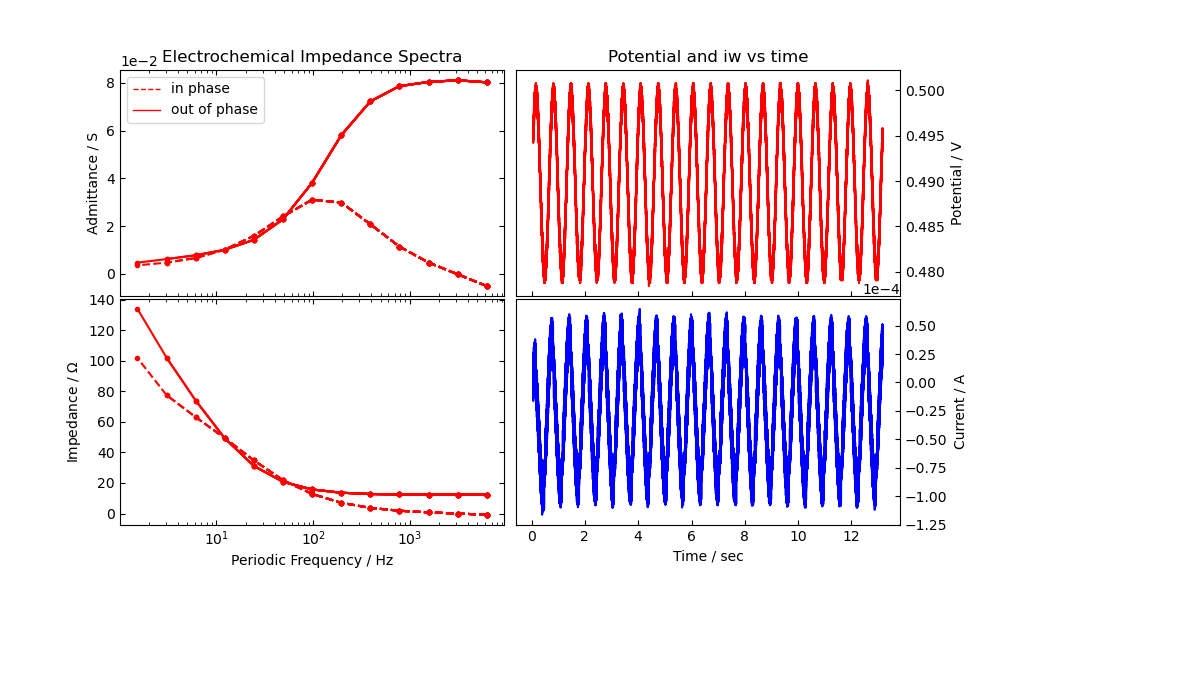

<IPython.core.display.Javascript object>


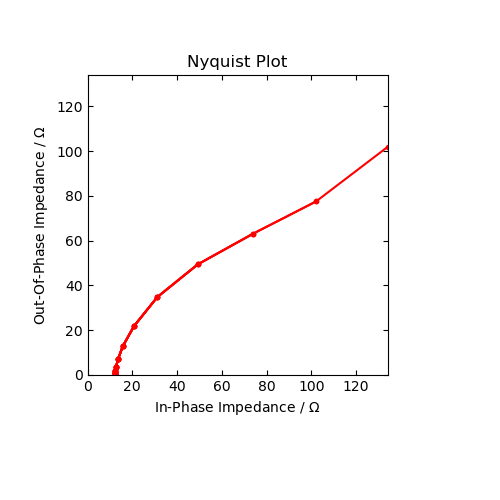

Name of measurement:


In [44]:
'''CELL BLOCK 1'''
import matplotlib.pyplot as plt
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; width:250em}</style>"))

'''basic acquisition params'''
E_DC = .488  # DC component of program potential 
E_AC = 0.01  # AC component of program potential
Rm = 1000 # Rm resistance in Ohms
samp_rate = 100000 # sampling rate in samples/s. Use max two channel acquisition rate of DAQ.
low_freq = 1 # frequencies will be betwen samp_rate/4 and low_freq
extra_samps = 6000 # extra samples 
ai1_delay = 8.5e-6  # ai1 is delayed wrt ai0 by this time in seconds 

# lists and arrays to to store data
freq_list = []
Yin_total = []
Yout_total = []
Zin_total =[]
Zout_total = []
time = []

from cycler import cycler
cc1 = (cycler(color=list('rgbcmy')) *
    cycler(linestyle=['-', '--']))
cc2 = (cycler(color=list('rgbcmy')))

# set up a 2 x 2 grid for the admittance plot
grid = plt.GridSpec(2, 2, wspace=0.03, hspace=0.01)
fig2 = plt.figure("Figure 2", figsize = (12,7))   
ax1 = fig2.add_subplot(grid[0, 0]) # in phase admittance
ax2 = fig2.add_subplot(grid[1, 0], sharex = ax1) # out of phase admittance
ax3 = fig2.add_subplot(grid[0, 1]) # potential vs time
ax4 = fig2.add_subplot(grid[1, 1], sharex = ax3) # current vs time
fig2.subplots_adjust(left=0.1, bottom=0.25, right=0.75, top=0.9, wspace=0, hspace=0.03)
plt.ion()
fig2.show()
fig2.canvas.draw()

# manually add legend
lines = Line2D([0], [0], color='red', label='in phase', linewidth=1, linestyle='--') 
lines2= Line2D([0], [0], color='red', label='out of phase', linewidth=1, linestyle='-') 


# set up Nyquist plot
fig3 = plt.figure("Figure 3", figsize = (5, 5))
ax5 = fig3.add_subplot()
fig3.subplots_adjust(left=0.15, bottom=0.25, right=0.8, top=0.85, wspace=0, hspace=0.03)


# frequency list we always want to sample four or more points per period. 
freq = samp_rate/16
while freq >= low_freq:    
    
    # acquire data for each frequency. 
    Ecell, iw, time, Yin, Yout, Zin, Zout = measure_Y_and_Z(E_DC, E_AC, freq, Rm, samp_rate, extra_samps, ai1_delay)

    # append data
    freq_list.append(freq)
    Yin_total.append(Yin)
    Yout_total.append(Yout)
    Zin_total.append(Zin)
    Zout_total.append(Zout)

    # subplot 1
    ax1.set_title('Electrochemical Impedance Spectra')
    ax1.tick_params(axis='both',which='both',direction='in',right=True, top=True)
    ax1.tick_params(labelbottom=False) 
    ax1.set_prop_cycle(cc1)
    ax1.plot(freq_list, Yin_total, marker = '.') #, label = '$R_{ct}$=' + str(Rct0) +'$\Omega; R_{u}$=' + str(Ru) +'$\Omega$ in-phase')
    ax1.plot(freq_list, Yout_total, marker = '.') #, label = '$R_{ct}$=' + str(Rct0) +'$\Omega; R_{u}$=' + str(Ru) +'$\Omega$ out-of-phase')
    ax1.set_ylabel('Admittance / S')
    ax1.set_xscale('log')
    ax1.ticklabel_format(axis = 'y', style='sci', scilimits = (-2, 3)) 
    ax1.legend(handles = [lines, lines2])
    #ax1.legend()
    #ax1.set_yscale('log')


    # subplot 2
    ax2.tick_params(axis='both',which='both',direction='in',right=True, top=True)
    ax2.set_prop_cycle(cc1)
    ax2.plot(freq_list, Zin_total, marker = '.')
    ax2.plot(freq_list, Zout_total, marker = '.')
    ax2.set_ylabel('Impedance / $\Omega$')
    ax2.set_xlabel('Periodic Frequency / Hz')
    ax2.set_xscale('log')
    #ax2.ticklabel_format(axis = 'y', style='sci', scilimits = (-2, 3)) 
    
    # clear subplots 3 and 4 to plot potential and current from most recent frequency 
    ax3.clear()
    ax4.clear()
    
    # subplot 3
    ax3.set_title('Potential and iw vs time')
    ax3.tick_params(axis='both',which='both',direction='in')
    ax3.set_prop_cycle(cc1)
    ax3.plot(time, Ecell)
    ax3.set_ylabel('Potential / V')
    ax3.set_xlabel('Time / sec')
    ax3.yaxis.set_ticks_position("right")
    ax3.yaxis.set_label_position("right")
    ax3.ticklabel_format(axis = 'y', style='sci', scilimits = (-2, 2))
    #ax3.axes.xaxis.set_ticklabels([])
    
    #ax3.set_xscale('log')
   # ax3.ticklabel_format(axis = 'y', style='sci', scilimits = (-2, 3)) 
    
    
    # subplot 4
    ax4.tick_params(axis='both',which='both',direction='in')
    ax4.set_prop_cycle(cc1)
    ax4.plot(time, iw, color = 'blue')
    ax4.set_ylabel('Current / A')
    ax4.set_xlabel('Time / sec')
    ax4.ticklabel_format(axis = 'y', style='sci', scilimits = (-2, 2))
    ax4.yaxis.set_ticks_position("right")
    ax4.yaxis.set_label_position("right")
    
    
    #ax3.set_xscale('log')
   # ax3.ticklabel_format(axis = 'y', style='sci', scilimits = (-2, 3)) 
    
    
    #fig2.canvas.draw()
    
    #ax2.set_yscale('log')

    # subplot 3
    #fig3 = plt.figure("Figure 3", figsize = (4, 4))
    #fig3.subplots_adjust(left=0.15, bottom=0.1, right=0.95, top=0.9, wspace=0, hspace=0.03)
    #ax3 = fig3.add_subplot()

    ax5.set_title('Nyquist Plot')
    ax5.tick_params(axis='both',which='both',direction='in',right=True, top=True)
    ax5.set_prop_cycle(cc2)
    ax5.plot(Zin_total, Zout_total, marker = '.')
    ax5.set_ylabel('Out-Of-Phase Impedance / $\Omega$')
    ax5.set_xlabel('In-Phase Impedance / $\Omega$')
    ax5.set_aspect('equal', 'box')
    
    if (max(Zin_total) >= max(Zout_total)):
        axes_max = max(Zin_total)
    else:
        axes_max = max(Zout_total)
    ax5.set_xlim ([0,axes_max])
    ax5.set_ylim ([0,axes_max])
    ax5.ticklabel_format(axis = 'y', style='sci', scilimits = (-2, 3)) 
    ax5.ticklabel_format(axis = 'x', style='sci', scilimits = (-2, 3)) 
    #ax3.legend()

    
    # update plots
    #ax3.clear()
    #ax4.clear()
    fig2.canvas.draw()
    fig3.canvas.draw()
    
    freq = freq/2 # Separating frequencies by factors of 2 gives a bit more than 3 values per decade

# ask for the name of measurement this will be used for the filenames for the exported data and plots
filename = input('Name of measurement:')

#export data
exported_data = pd.DataFrame({'Frequency/Hz': freq_list, 'Y_in/S': Yin_total, 'Y_out/S': Yout_total, 
                              'Z_in/ohms': Zin_total, 'Z_out/ohms':Zout_total})
exported_data.to_csv(filename + '.txt', index = False)



# Comparing EIS data with model

In this section you will import EIS data and adjust the model used in the prelab to match the collected data. 

In [6]:
'''Import data'''

# filename
file = 'EIS at half wave.txt'

# import data
data = pd.read_csv(file)

In [7]:
data.columns

Index(['Frequency/Hz', 'Y_in/S', 'Y_out/S', 'Z_in/ohms', 'Z_out/ohms'], dtype='object')

In [53]:
'''model parameters'''

E0 = 0.488 # standard potential of redox couple in V
n=1 # number of electrons per rxn
F=96485 # charge of electron in C/mol
R=8.31 # gas constant in J/mol/K
T=298 # temperature in K
A=1.3 # area in cm^2
D=5**-6# diffusion constant in cm^2/s
ctotal=1e-6 # total concentration of redox species in mol/cm^3
Rct0 = 50 # charge-transfer resistance at E0 in ohms
Cd = 500e-6 #  double layer capacitanc1e in F
# Ru = 0 # uncompensated cell resistance in ohms

'''EIS Experimental Parameters'''
E_DC_EIS = .488 # DC potential of EIS in volts
Ru = 5 # uncompensated cell resistance in ohms

<IPython.core.display.Javascript object>


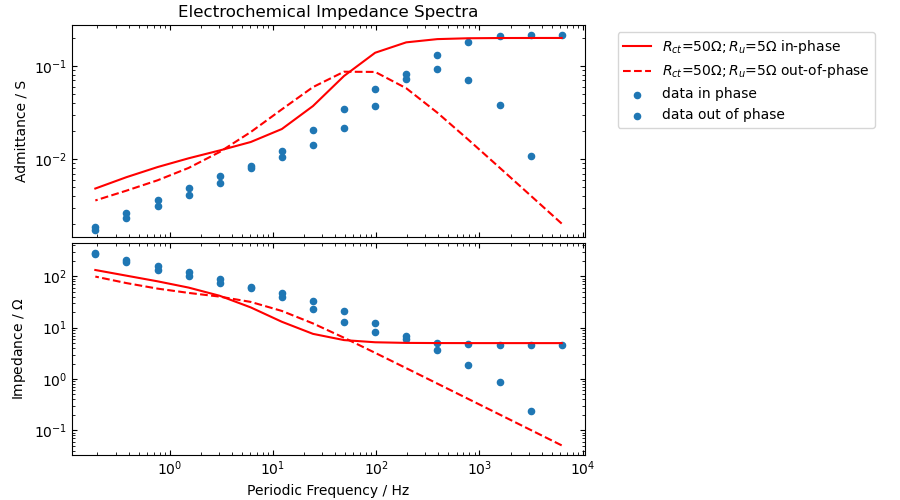

<IPython.core.display.Javascript object>


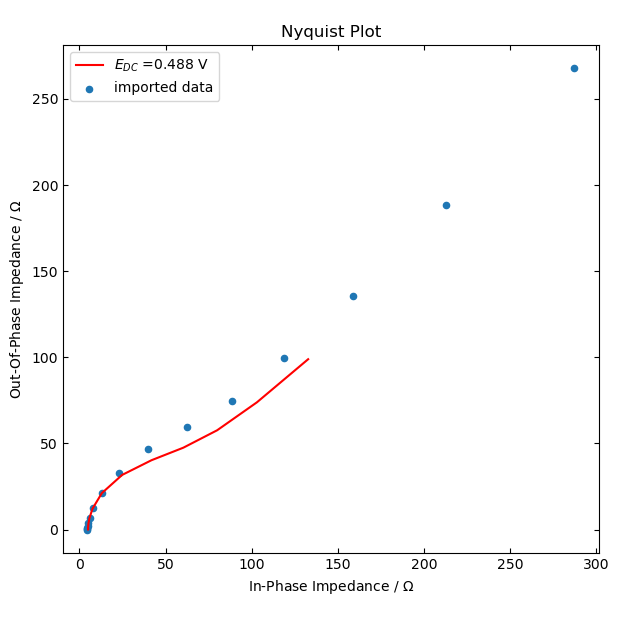

'SAVE FIGURE'

In [54]:
'''Plot imported data with model'''

import matplotlib
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 70em; width:150em}</style>"))


# Frequency range array for EIS (default freq range goes from 0.1 Hz to 100 kHz )
powers = np.arange(-1, 5.1, 0.1)
freq_range = np.array(data['Frequency/Hz'])

'''calcuate admittances and impedances of EIS by progressively adding components'''
# lists to store EIS sweep results
EIS_freq =[]
Yin_EIS_total=[]
Yout_EIS_total=[]
Zin_EIS_total=[]
Zout_EIS_total=[]

for f_EIS in freq_range:
    
    # charge transfer resistance for redox assuming alpha = 0.5
    Rct_EIS = Rct0*(exp((E_DC_EIS-E0)/(2*R*T/n/F))+exp(-(E_DC_EIS-E0)/(2*R*T/n/F)))/2
    # equation 13 with E_cell replaced by E_DC
    Credox_EIS = (n**2*F**2/R/T)*A*(D/(2*pi*f_EIS))**0.5*ctotal*exp(-(E_DC_EIS-E0)/(R*T/n/F))*(1+exp(-(E_DC_EIS-E0)/(R*T/n/F)))**(-2)
    
    # in/out of-phase impedance of charge transfer
    Zin_EIS = Rct_EIS
    Zout_EIS = 0
    
    #in/out-of-phase impedance of redox branch of circuit
    Zin_EIS = Zin_EIS + 1./(2*pi*f_EIS*Credox_EIS)
    Zout_EIS = 1/(2*pi*f_EIS*Credox_EIS)
    
    #in/out-of-phase admittance of redox branch of circuit
    Yin_EIS = Zin_EIS/(Zin_EIS**2 + Zout_EIS**2)
    Yout_EIS = Zout_EIS/(Zin_EIS**2 + Zout_EIS**2)
    
    # in/out-of-phase admittance of redox and double-layer parallel branches of circuit
    Yin_EIS = Yin_EIS 
    Yout_EIS = Yout_EIS + 2*pi*f_EIS*Cd
    
    #in/out-of-phase impedance of redox and double-layer parallel branches of circuit
    Zin_EIS = Yin_EIS/(Yin_EIS**2 + Yout_EIS**2)
    Zout_EIS = Yout_EIS/(Yin_EIS**2 + Yout_EIS**2)
    
    #in/out of-phase impedance of entire circuit
    Zin_EIS = Zin_EIS + Ru
    Zout_EIS = Zout_EIS
    
    #in/out of-phase admittance of entire circuit
    Yin_EIS = Zin_EIS/(Zin_EIS**2 + Zout_EIS**2)
    Yout_EIS = Zout_EIS/(Zin_EIS**2 + Zout_EIS**2)
    
    # append data
    EIS_freq.append(f_EIS) 
    Yin_EIS_total.append(Yin_EIS)
    Yout_EIS_total.append(Yout_EIS)
    Zin_EIS_total.append(Zin_EIS)
    Zout_EIS_total.append(Zout_EIS)
    
# set up a 2 x 1 grid for the plot
grid = plt.GridSpec(2, 1, wspace=0, hspace=0.03)
fig5 = plt.figure("Figure 2", figsize = (9, 5))   
ax1 = fig5.add_subplot(grid[0, 0])
ax2 = fig5.add_subplot(grid[1, 0], sharex = ax1)

fig5.subplots_adjust(left=0.08, bottom=0.09, right=0.65, top=0.95, wspace=0, hspace=0.03)

from cycler import cycler
cc1 = (cycler(color=list('rgbcmy')) *
      cycler(linestyle=['-', '--']))
cc2 = (cycler(color=list('rgbcmy')))

# subplot 1
ax1.set_title('Electrochemical Impedance Spectra')
ax1.tick_params(axis='both',which='both',direction='in',right=True, top=True)
ax1.tick_params(labelbottom=False) 
ax1.set_prop_cycle(cc1)
ax1.plot(EIS_freq, Yin_EIS_total, label = '$R_{ct}$=' + str(Rct0) +'$\Omega; R_{u}$=' + str(Ru) +'$\Omega$ in-phase')
ax1.plot(EIS_freq, Yout_EIS_total, label = '$R_{ct}$=' + str(Rct0) +'$\Omega; R_{u}$=' + str(Ru) +'$\Omega$ out-of-phase')
data.plot(kind = 'scatter', x = 'Frequency/Hz', y = 'Y_in/S', label = 'data in phase', ax=ax1 ) # plot in phase admittance from imported data
data.plot(kind = 'scatter', x = 'Frequency/Hz', y = 'Y_out/S', label = 'data out of phase', ax=ax1 ) # plot out of phase admittance from imported data

ax1.set_ylabel('Admittance / S')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # move the legend

# subplot 2
ax2.tick_params(axis='both',which='both',direction='in',right=True, top=True)
ax2.set_prop_cycle(cc1)
ax2.plot(EIS_freq, Zin_EIS_total)
ax2.plot(EIS_freq, Zout_EIS_total)
data.plot(kind = 'scatter', x = 'Frequency/Hz', y = 'Z_in/ohms', ax=ax2 ) # plot in phase impedance from imported data
data.plot(kind = 'scatter', x = 'Frequency/Hz', y = 'Z_out/ohms', ax=ax2 ) # plot out of phase impedance from imported data

ax2.set_ylabel('Impedance / $\Omega$')
ax2.set_xlabel('Periodic Frequency / Hz')
ax2.set_xscale('log')
ax2.set_yscale('log')

# subplot 3
fig3 = plt.figure("Figure 3", figsize = (6.3, 6.3))
fig3.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.95, wspace=0, hspace=0.03)
ax3 = fig3.add_subplot()

ax3.set_title('Nyquist Plot')
ax3.tick_params(axis='both',which='both',direction='in',right=True, top=True)
ax3.set_prop_cycle(cc2)
ax3.plot(Zin_EIS_total, Zout_EIS_total, label = '$E_{DC}$ =' + str(E_DC_EIS) +' V')
data.plot(kind = 'scatter', x = 'Z_in/ohms', y = 'Z_out/ohms', label = 'imported data', ax=ax3 ) # plot imported data
ax3.set_ylabel('Out-Of-Phase Impedance / $\Omega$')
ax3.set_xlabel('In-Phase Impedance / $\Omega$')
ax3.legend()
ax3.set_aspect('equal', 'box')
'''if (max(Zin_EIS_total) >= max(Zout_EIS_total)):
    axes_max = max(Zin_EIS_total)
else:
    axes_max = max(Zout_EIS_total)
ax3.set_xlim ([0,axes_max])
ax3.set_ylim ([0,axes_max])
'''
'''SAVE FIGURE'''
#plt.savefig(file + '.png', dpi = 300, bbox_inches='tight')